In [1]:
import json
import pandas as pd
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import seaborn as sns

## Read all extracted data files and save them into one file
### Interpolate spectrum into specific length

In [28]:
def interpolate_spec(spectrum,length=100,seed=0):
    '''
    ## Interpolate the spectrum to a new length
        - Firstly the energy range is interpolated to the desired length, typically 100 for XANES and 500 for EXAFS
        - Then the intensity is interpolated using the linear interpolation and newly interpolated energy range

    ### Args:
        - spectrum: numpy array, shape=(n,2), the first column is the energy and the second column is the intensity
        - length: int, the length of the new spectrum
        - seed: int, random seed for reproducibility

    ### Returns:
        - new_spectrum: numpy array, shape=(length,2), the first column is the energy and the second column is the intensity
    '''
    np.random.seed(seed)
    X_val = spectrum[:, 0]
    Y_val = spectrum[:, 1]
    sorted_indices = np.argsort(X_val)
    X_val = X_val[sorted_indices]
    Y_val = Y_val[sorted_indices]
    if len(X_val) == length:
        return np.column_stack((X_val, Y_val))
    else:
        x_tmp = np.interp(np.linspace(0, len(X_val)-1, length*4), np.arange(len(X_val)), X_val)
        x_tmp = np.random.choice(x_tmp,length,replace=False) # To avoid the interpolation error caused by the length-len(X_val)>len(new_X)
        if len(X_val)<length:
            new_X=np.setdiff1d(np.unique(np.concatenate((X_val,x_tmp))),X_val)
            inter_choice=np.random.choice(new_X,length-len(X_val),replace=False)
            new_X=np.concatenate((X_val,inter_choice))
            new_sort=np.argsort(new_X)
            new_X=new_X[new_sort]
        else:
            new_X=x_tmp
        # new_X = x_tmp
        interpolator = interp1d(X_val, Y_val, kind='linear', fill_value='extrapolate')
        new_Y = interpolator(new_X)
        new_spectrum = np.column_stack((new_X, new_Y))
        return new_spectrum

ann_mm=pd.read_excel('../documentation/MolStruc_doc.xlsx')
ann_mm.fillna('',inplace=True)
ann_mm.head()

xas_folder='../extracted_data'
key2folders=json.load(open('../key2folders.json','r'))

protein_data=[]
_info={}
i=1
xanes_len=[]
exafs_len=[]
protein_num=0
while i<len(ann_mm):
    if ann_mm['Key'][i]!='':
        if _info!= {}:
            try:
                protein_data.append(_info)
            except:
                print(_info)
        _info={'Key':'','Title':'','URL':'','DOI':'',
               'Structure_Data':{'XANES':[],'EXAFS':[],'SMILES':[],'PDB':[],'CCDC':[],'Notes':[]},
               'Spectra_Data':{'XANES':[],'EXAFS':[],'Notes':[]}}
        _key=ann_mm['Key'][i]
        _title=ann_mm['Title'][i]
        _url=ann_mm['Url'][i]
        _doi=ann_mm['DOI'][i]
        _standards=ann_mm['XANES'][i]
        _ligation=ann_mm['Unnamed: 5'][i]
        _sample=ann_mm['Unnamed: 6'][i]
        _exafs_sample=ann_mm['EXAFS'][i]
        _smiles=ann_mm['SMILES'][i]
        _pdb=ann_mm['PDB'][i]
        _cdcc=ann_mm['CCDC'][i]
        _notes=ann_mm['NOTES'][i]

        _info['Key']=_key
        _info['Title']=_title
        _info['URL']=_url
        _info['DOI']=_doi
        if _key in key2folders.keys():
            spectra_folder=os.path.join(xas_folder,key2folders[_key])
            if os.path.exists(spectra_folder):
                for file in os.listdir(spectra_folder):
                    if 'XANES'==file or 'EXAFS'==file:
                        _file_path=os.path.join(spectra_folder,file)
                        for xanes_file in os.listdir(_file_path):
                            if os.path.isdir(os.path.join(_file_path,xanes_file)):
                                _fig_name=xanes_file
                                for data_file in os.listdir(os.path.join(_file_path,xanes_file)):
                                    if data_file.endswith('.csv'):
                                        _data_name=data_file.split('.')[0]
                                        _edge=''
                                        _data=pd.read_csv(os.path.join(_file_path,xanes_file,data_file),header=None)
                                        _data=_data.sort_values(by=0)
                                        _data=_data.to_numpy()
                                        _data=interpolate_spec(_data,length=100).tolist()
                                        if file=='XANES':
                                            xanes_len.append(len(_data))
                                        else:
                                            exafs_len.append(len(_data))
                                        _info['Spectra_Data'][file].append({'fig_name':_fig_name,'data_name':_data_name,'edge':_edge,'data':_data})
        else:
            print(_key)
        if _standards!='' or  _ligation!='' or  _sample!='' or _exafs_sample!='' or _smiles!='' or _pdb!='' or _cdcc!='' or _notes!='':
            _info['Structure_Data']['XANES'].append({'Standards':_standards,'Ligation':_ligation,'Sample':_sample})
            _info['Structure_Data']['EXAFS'].append({'Sample':_exafs_sample})
            _info['Structure_Data']['SMILES'].append(_smiles)
            _info['Structure_Data']['PDB'].append(_pdb)
            _info['Structure_Data']['CCDC'].append(_cdcc)
            _info['Structure_Data']['Notes'].append(_notes)
            if _standards!='' or  _ligation!='' or  _sample!='' or _exafs_sample!='' or _smiles!='' or _pdb!='' or _cdcc!='':
                protein_num+=1
        i+=1
    else:
        _standards=ann_mm['XANES'][i]
        _ligation=ann_mm['Unnamed: 5'][i]
        _sample=ann_mm['Unnamed: 6'][i]
        _exafs_sample=ann_mm['EXAFS'][i]
        _smiles=ann_mm['SMILES'][i]
        _pdb=ann_mm['PDB'][i]
        # _pdb_proteins=ann_mm['proteins that have a pdb now'][i]
        _cdcc=ann_mm['CCDC'][i]
        _notes=ann_mm['NOTES'][i]
        if _standards!='' or  _ligation!='' or  _sample!='' or _exafs_sample!='' or _smiles!='' or _pdb!='' or _cdcc!='' or _notes!='':
            _info['Structure_Data']['XANES'].append({'Standards':_standards,'Ligation':_ligation,'Sample':_sample})
            _info['Structure_Data']['EXAFS'].append({'Sample':_exafs_sample})
            _info['Structure_Data']['SMILES'].append(_smiles)
            _info['Structure_Data']['PDB'].append(_pdb)
            _info['Structure_Data']['CCDC'].append(_cdcc)
            _info['Structure_Data']['Notes'].append(_notes)
        i+=1
json.dump(protein_data,open('protein_data.json','w'))
len(protein_data),protein_num,len(xanes_len),len(exafs_len),len(xanes_len)+len(exafs_len)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


(517, 437, 1283, 369, 1652)

### Plot Distribution of XAS lengths

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


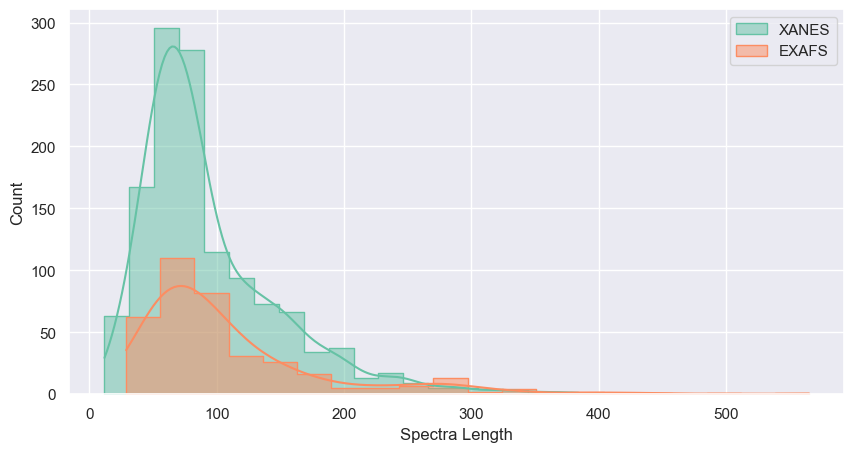

In [25]:
sns.set_theme(palette='Set2')
plt.figure(figsize=(10,5))
sns.histplot(xanes_len,kde=True,label='XANES',alpha=0.5,bins=20,stat='count',common_norm=False,element='step')
sns.histplot(exafs_len,kde=True,label='EXAFS',alpha=0.5,bins=20,stat='count',common_norm=False,element='step')
plt.legend()
plt.ylabel('Count')
plt.xlabel('Spectra Length')
plt.savefig('./spectra_len.png',dpi=300,bbox_inches='tight',pad_inches=0.1)
plt.show()